# Gen-LM-with-LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from tensorflow.keras import layers
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
filepath = "/content/drive/MyDrive/Colab Notebooks/ML projects/poems/"

In [4]:
lines = []

def extract_lines(file, lines):
  with open(file) as f:
    for line in f:
      line = line.strip()
      if line:
        lines.append(line)

for i in range(1, 11):
  extract_lines(f"{filepath}/Poem_{i}.txt",lines)

n_lines = len(lines)

In [5]:
n_lines

300000

In [6]:
import os
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [7]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [9]:
def preprocess_text(lines):
    cleaned_lines = []
    for line in lines:
        line = line.lower()
        line = line.translate(str.maketrans("", "", string.punctuation))
        words = word_tokenize(line)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        cleaned_lines.append(" ".join(words))
    return cleaned_lines

cleaned_lines = preprocess_text(lines)

In [10]:
text = '\n'.join(cleaned_lines)

vocab = sorted(set(text))
vocab.insert(0, '[UNK]')
vocab.insert(1, '')

print(f'{len(vocab)} unique characters')
print(vocab[:100])

25 unique characters
['[UNK]', '', '\n', ' ', 'a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [11]:
def line_to_tensor(line, vocab):
    chars = tf.strings.unicode_split(input=line, input_encoding='UTF-8')
    ids = layers.StringLookup(vocabulary=vocab, mask_token=None)(chars)
    return ids

sample_line = "The moon stands guard in silver hue"
tensor_output = line_to_tensor(sample_line, vocab)
print(tensor_output)


tf.Tensor(
[ 0 10  7  3 14 16 16 15  3 19 20  4 15  6 19  3  9 21  4 18  6  3 11 15
  3 19 11 13 22  7 18  3 10 21  7], shape=(35,), dtype=int64)


In [12]:
def text_from_ids(ids, vocab):
    chars = layers.StringLookup(vocabulary=vocab, mask_token=None, invert=True)(ids)
    text = tf.strings.reduce_join(chars, axis=-1)
    return text.numpy().decode('UTF-8')

In [13]:
train_lines = cleaned_lines[0:-5000]
eval_lines = cleaned_lines[-5000:]

In [14]:
print(f"Total number of lines: {len(cleaned_lines)}")
print(f"Number of training lines: {len(train_lines)}")
print(f"Number of evaluation lines: {len(eval_lines)}")

Total number of lines: 300000
Number of training lines: 295000
Number of evaluation lines: 5000


In [15]:
def split_input_target(sequence):

    # Create the input sequence by excluding the last character
    input_text = sequence[:-1]
    # Create the target sequence by excluding the first character
    output_text = sequence[1:]

    return input_text, output_text

In [16]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [17]:
def create_batch_dataset(lines, vocab, seq_length=100, batch_size=64):

    single_line = '\n'.join(lines)

    all_ids = line_to_tensor(line=single_line, vocab=vocab)

    ds_ids = tf.data.Dataset.from_tensor_slices(all_ids)

    ds_ids = ds_ids.batch(batch_size=seq_length+1, drop_remainder=True)

    ds_xy = ds_ids.map(split_input_target)

    ds = ds_xy.batch(batch_size=batch_size, drop_remainder=True)\
              .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [18]:
ds_train = create_batch_dataset(lines=train_lines, vocab=vocab, seq_length=100, batch_size=64)
ds_eval = create_batch_dataset(lines=eval_lines, vocab=vocab, seq_length=100, batch_size=64)

In [19]:
for x_batch, y_batch in ds_train.take(1):
    x_1 = x_batch[0]
    y_1 = y_batch[0]
    print(f"x_1: {x_1}")
    print(f"y_1: {y_1}", "\n")
    print(f"x_1: {text_from_ids(x_1, vocab)}")
    print(f"y_1: {text_from_ids(y_1, vocab)}")

x_1: [ 6 18  7  4 14  3 20 11 14  7  3 19 10  4  6 16 23  3 19 20  4 18  3  6
 18  7  4 14  3 13 11  9 10 20  3  9 13 16 23  3 19 12 24  3 18 11 22  7
 18  3 19 10  4  6 16 23  2 15 11  9 10 20  3  8 11 18  7  3 16  5  7  4
 15  3  9 13 16 23  3  8 11 18  7  3 23 10 11 19 17  7 18  3 14 16 16 15
  3 23 10 11]
y_1: [18  7  4 14  3 20 11 14  7  3 19 10  4  6 16 23  3 19 20  4 18  3  6 18
  7  4 14  3 13 11  9 10 20  3  9 13 16 23  3 19 12 24  3 18 11 22  7 18
  3 19 10  4  6 16 23  2 15 11  9 10 20  3  8 11 18  7  3 16  5  7  4 15
  3  9 13 16 23  3  8 11 18  7  3 23 10 11 19 17  7 18  3 14 16 16 15  3
 23 10 11 19] 

x_1: dream time shadow star dream light glow sky river shadow
night fire ocean glow fire whisper moon whi
y_1: ream time shadow star dream light glow sky river shadow
night fire ocean glow fire whisper moon whis


In [20]:
input = layers.Input(shape=(None,))

x = layers.Embedding(input_dim=len(vocab), output_dim=256)(input)

lstm_output = layers.LSTM(
    units=512, activation='tanh', dropout=0.5, recurrent_dropout=0.5, return_sequences=True
)(x) # return_state=True

output = layers.Dense(units=len(vocab), activation=tf.nn.log_softmax)(lstm_output)

model = tf.keras.Model(inputs=input, outputs=output)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 256)           │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 512)           │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 25)            │          12,825 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,594,137 (6.08 MB)

 Trainable params: 1,594,137 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00125),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

In [23]:
history = model.fit(ds_train, epochs=5, verbose=2)

Epoch 1/5
1934/1934 - 391s - 202ms/step - loss: 0.6681
Epoch 2/5
1934/1934 - 430s - 222ms/step - loss: 0.6188
Epoch 3/5
1934/1934 - 382s - 197ms/step - loss: 0.6180
Epoch 4/5
1934/1934 - 383s - 198ms/step - loss: 0.6176
Epoch 5/5
1934/1934 - 382s - 197ms/step - loss: 0.6173


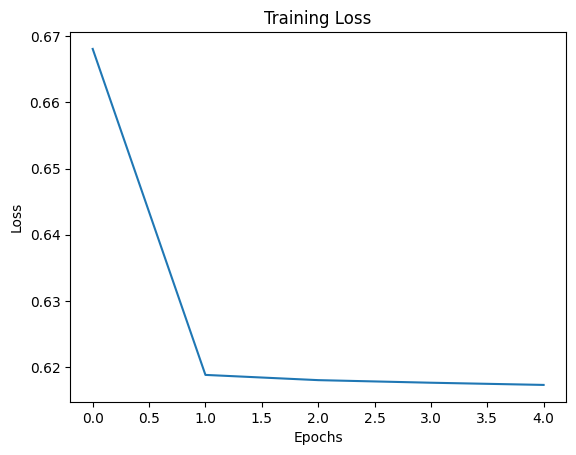

In [24]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [25]:
model.save_weights('model.weights.h5')

In [26]:
input_seq  = layers.Input(shape=(None,))

initial_forward_h = layers.Input(shape=(512,))
initial_forward_c = layers.Input(shape=(512,))

x = layers.Embedding(input_dim=len(vocab), output_dim=256)(input_seq)

lstm_output, forward_h, forward_c = layers.LSTM(
    units=512, activation='tanh', return_sequences=True, return_state=True
)(x, initial_state=[initial_forward_h, initial_forward_c])

output = layers.Dense(units=len(vocab), activation=tf.nn.log_softmax)(lstm_output)

inference_model = tf.keras.Model(
    inputs=[input_seq, initial_forward_h, initial_forward_c],
    outputs=[output, forward_h, forward_c]
)

In [27]:
inference_model.load_weights("model.weights.h5")

In [28]:
inference_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │          6,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 512),    │      1,574,912 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ input_layer_2[0][0],   │
│                           │ 512)]                  │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 25)       │         12,825 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,594,137 (6.08 MB)

 Trainable params: 1,594,137 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
def log_perplexity(preds, target):
    PADDING_ID = 1

    # Calculate log probabilities for predictions using one-hot encoding
    log_p = np.sum(preds * tf.one_hot(target, depth=preds.shape[-1]), axis= -1)
    # Identify non-padding elements in the target
    non_pad = 1.0 - np.equal(target, PADDING_ID)
    # Apply non-padding mask to log probabilities to exclude padding
    log_p = log_p * non_pad                             # Get rid of the padding
    # Calculate the log perplexity by taking the sum of log probabilities and dividing by the sum of non-padding elements
    log_ppx = np.sum(log_p, axis=-1) / np.sum(non_pad, axis=-1)
    # Compute the mean of log perplexity
    log_ppx = np.mean(log_ppx)

    return -log_ppx

In [30]:
x = []
y = []

for x_batch, y_batch in ds_eval:
    x.append(x_batch)
    y.append(y_batch)

x = tf.concat(x, axis=0)
y = tf.concat(y, axis=0)

In [31]:
initial_state = tf.zeros((x.shape[0], 512))

predicted_logits, _, _ = inference_model.predict(
    [x, initial_state, initial_state], verbose=1
)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [32]:
log_ppx = log_perplexity(predicted_logits, y)
print(f'The log perplexity and perplexity of the model are {log_ppx:.3f} and {np.exp(log_ppx):.3f} respectively')

The log perplexity and perplexity of the model are 0.617 and 1.853 respectively


In [33]:
def temperature_random_sampling(log_probs, temperature=1.0):
    """Temperature Random sampling from a categorical distribution. The higher the temperature, the more
       random the output. If temperature is close to 0, it means that the model will just return the index
       of the character with the highest input log_score

    Args:
        log_probs (tf.Tensor): The log scores for each characeter in the dictionary
        temperature (number): A value to weight the random noise.
    Returns:
        int: The index of the selected character
    """
   # Generate uniform random numbers with a slight offset to avoid log(0)
    u = tf.random.uniform(minval=1e-6, maxval=1.0 - 1e-6, shape=log_probs.shape)

    # Apply the Gumbel distribution transformation for randomness
    g = -tf.math.log(-tf.math.log(u))

    # Adjust the logits with the temperature and choose the character with the highest score
    return tf.math.argmax(log_probs + g * temperature, axis=-1)

In [34]:
tf.config.run_functions_eagerly(True)

class GenerativeModel(tf.keras.Model):
    def __init__(self, model, vocab, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.vocab = vocab

    @tf.function
    def generate_one_step(self, inputs, states):

        input_ids = line_to_tensor(inputs, self.vocab)
        input_ids = input_ids.to_tensor()

        predicted_logits, forward_h, forward_c = self.model(
            [input_ids, *states], training=False
        ) # output, forward_h, forward_c

        # Get only last element of the sequence (last char)
        predicted_logits = predicted_logits[0, -1, :]

        predicted_ids = temperature_random_sampling(predicted_logits, self.temperature)

        predicted_chars = text_from_ids([predicted_ids], self.vocab)

        new_states = (forward_h, forward_c)

        return tf.expand_dims(predicted_chars, 0), new_states

    def generate_n_chars(self, num_chars, prefix):
        states = (
            tf.zeros((1, 512)),  # Forward hidden state
            tf.zeros((1, 512)),  # Forward cell state
        )

        next_char = tf.constant([prefix])
        result = [next_char]
        for _ in range(num_chars):
            next_char, states = self.generate_one_step(next_char, states)
            result.append(next_char)

        return tf.strings.join(result)[0].numpy().decode('utf-8')

In [35]:
start = "life"
n_chars = 300

tf.random.set_seed(101)

tic = time.time()

gen = GenerativeModel(inference_model, vocab, temperature=0.2)
poem = gen.generate_n_chars(n_chars, start)

toc = time.time()

print(poem)
print(f"\n\nRun time on GPU: {toc-tic:.1f}s")

lifer mystery sun star star sun sun moon
memory sky star sun soul soul star soul sky shadow sun
star star star soul shadow soul sky sun sun sun star shadow
sun star sun sun sun memory shadow soul sun
shadow soul sun shadow star sun star moon star star memory soul sky
sun star shadow sun sky shadow star 


Run time on GPU: 8.0s


In [36]:
start = "moonlight"
n_chars = 1000

tf.random.set_seed(1000)

tic = time.time()

gen = GenerativeModel(inference_model, vocab, temperature=0.2)
poem = gen.generate_n_chars(n_chars, start)

toc = time.time()

print(poem)
print(f"\n\nRun time on GPU: {toc-tic:.1f}s")

moonlight sky sky memory star star sun soul star star star soul
star sun star soul soul star soul soul star star dance
sun star star shadow soul sun soul sun sun soul sky star
star sun soul shadow sky star sun shadow star sun star
star sky sky shadow star star sun star soul shadow moon star shadow sun sun
star sun star mystery sky sun sun shadow star whisper memory
heart sky soul moon star soul star soul shadow memory sky shadow
sky star sun soul whisper shadow soul sky soul ocean mystery
star sun sun sun soul star star memory sky sun shadow star
star memory star sky star star soul soul sky soul
soul soul star sun soul mystery star memory sky sky mystery
shadow sun soul star star sky star soul wind
sun shadow sun soul sun sky dream star soul sky star
star sun soul sun sun sun moon star sun star sun
soul sky sun soul soul star sun star sun star
soul star star sun star sky star soul soul sky sun
shadow sky memory star mystery mystery sky soul sun mystery
star star star shadow sky shadow 